In [50]:
import pandas as pd
import pyspark
import numpy as np
import torch as tor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [51]:
dataset = pd.read_csv('Galton_Family_Heights.csv')

In [52]:
dataset.head()

,Father_height,Mother_height,Child_height,gender
0,78.5,67.0,73.2,1
1,78.5,67.0,69.2,0
2,78.5,67.0,69.0,0
3,78.5,67.0,69.0,0
4,75.5,66.5,73.5,1


In [53]:
display(dataset.describe())
display(dataset.shape)

if dataset.isnull().sum().sum() > 0:
    print("There are missinng values)")
else:
    print("There are no missing values")

# gender: 0 for Female, 1 for Father

,Father_height,Mother_height,Child_height,gender
count,934.000000,934.000000,934.000000,934.000000
mean,69.197109,64.089293,66.745931,0.514989
std,2.476479,2.290886,3.579251,0.500043
min,62.000000,58.000000,56.000000,0.000000
25%,68.000000,63.000000,64.000000,0.000000
50%,69.000000,64.000000,66.500000,1.000000
75%,71.000000,65.875000,69.700000,1.000000
max,78.500000,70.500000,79.000000,1.000000


(934, 4)

There are no missing values


In [54]:
#Galton's Midparent forumula
#Enriching the datset with midparent height
dataset['Midparent_height'] = (dataset['Father_height'] + (1.08 * dataset['Mother_height'])) / 2

In [55]:
dataset. head()
display(dataset.describe())

,Father_height,Mother_height,Child_height,gender,Midparent_height
count,934.000000,934.000000,934.000000,934.000000,934.000000
mean,69.197109,64.089293,66.745931,0.514989,69.206773
std,2.476479,2.290886,3.579251,0.500043,1.802370
min,62.000000,58.000000,56.000000,0.000000,64.400000
25%,68.000000,63.000000,64.000000,0.000000,68.140000
50%,69.000000,64.000000,66.500000,1.000000,69.248000
75%,71.000000,65.875000,69.700000,1.000000,70.140000
max,78.500000,70.500000,79.000000,1.000000,75.430000


In [56]:
corr_mat_numeric = dataset.corr(numeric_only=True)

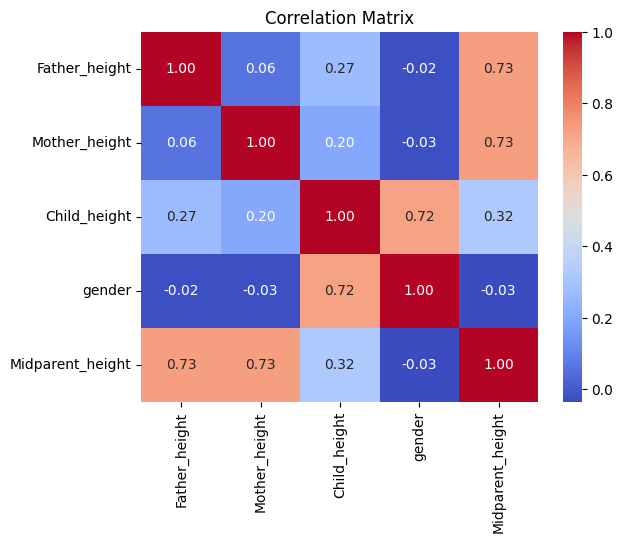

In [57]:
sns.heatmap(corr_mat_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [58]:
#Normalize Data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
independent = scaler.fit_transform(dataset[['Midparent_height', 'gender']])
dependent = scaler.fit_transform(dataset[['Child_height']])

#Train Test Split 
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=42)

x_train = tor.tensor(x_train, dtype=tor.float32)
x_test = tor.tensor(x_test, dtype=tor.float32)

y_train = tor.tensor(y_train, dtype=tor.float32)
y_test = tor.tensor(y_test, dtype=tor.float32)


In [59]:
#Build lindear regression model 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

In [60]:
#Train Model
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 2.3853
Epoch [51/500], Loss: 0.6548
Epoch [101/500], Loss: 0.4081
Epoch [151/500], Loss: 0.3728
Epoch [201/500], Loss: 0.3677
Epoch [251/500], Loss: 0.3670
Epoch [301/500], Loss: 0.3668
Epoch [351/500], Loss: 0.3668
Epoch [401/500], Loss: 0.3668
Epoch [451/500], Loss: 0.3668


In [61]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on all data
X_all = tor.tensor(independent, dtype=tor.float32)
y_all = tor.tensor(dependent, dtype=tor.float32)

model.eval()
y_pred_scaled = model(X_all).detach().numpy()
y_true_scaled = y_all.numpy()

# Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_true_original = scaler.inverse_transform(y_true_scaled)

# Calculate metrics
Mid_mae = mean_absolute_error(y_true_original, y_pred_original)
Mid_rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)
Mid_r2 = r2_score(y_true_original, y_pred_original)

print(f"Mid_MAE: {Mid_mae:.2f}")
print(f"Mid_RMSE: {Mid_rmse:.2f}")
print(f"Mid_R² Score: {Mid_r2:.3f}")


Mid_MAE: 1.72
Mid_RMSE: 2.17
Mid_R² Score: 0.633


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [62]:
dataset['Midheight_Prediction'] = y_pred_original.round(2)
dataset['Mid_MAE'] = Mid_mae
dataset['Mid_RMSE'] = Mid_rmse
dataset['Mid_R2'] = Mid_r2

In [71]:
##Normalize Data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
independent = scaler.fit_transform(dataset[['Father_height', 'Mother_height', 'gender']])
dependent = scaler.fit_transform(dataset[['Child_height']])

#Train Test Split 
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=42)

x_train = tor.tensor(x_train, dtype=tor.float32)
x_test = tor.tensor(x_test, dtype=tor.float32)

y_train = tor.tensor(y_train, dtype=tor.float32)
y_test = tor.tensor(y_test, dtype=tor.float32)


In [72]:
#Build lindear regression model 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

In [73]:
#Train Model
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 0.7123
Epoch [51/500], Loss: 0.4078
Epoch [101/500], Loss: 0.3683
Epoch [151/500], Loss: 0.3632
Epoch [201/500], Loss: 0.3626
Epoch [251/500], Loss: 0.3625
Epoch [301/500], Loss: 0.3625
Epoch [351/500], Loss: 0.3625
Epoch [401/500], Loss: 0.3625
Epoch [451/500], Loss: 0.3625


In [74]:
# Get weights and bias from trained model
weights = model.linear.weight.data.numpy()
bias = model.linear.bias.data.numpy()

print(f"Weights: {weights}")  
print(f"Bias: {bias}")
print(f"Intercept: {model.linear.bias.item()}") 

#Father is clearly more deterministic than the mother

Weights: [[0.27711347 0.18182364 0.7221153 ]]
Bias: [-0.00324943]
Intercept: -0.003249428002163768


In [84]:
display(dataset['Midheight_Prediction'].describe())
display(dataset.head())
display(dataset['Child_height'].describe())
display(len(dataset['Father_height'].unique()))

count    934.000000
mean      66.737381
std        2.800824
min       60.910000
25%       64.150000
50%       67.029999
75%       69.277498
max       73.349998
Name: Midheight_Prediction, dtype: float64

,Father_height,Mother_height,Child_height,gender,Midparent_height,Midheight_Prediction,Mid_MAE,Mid_RMSE,Mid_R2
0,78.5,67.0,73.2,1,75.43,73.349998,1.715124,2.167274,0.632964
1,78.5,67.0,69.2,0,75.43,68.190002,1.715124,2.167274,0.632964
2,78.5,67.0,69.0,0,75.43,68.190002,1.715124,2.167274,0.632964
3,78.5,67.0,69.0,0,75.43,68.190002,1.715124,2.167274,0.632964
4,75.5,66.5,73.5,1,73.66,72.180000,1.715124,2.167274,0.632964


count    934.000000
mean      66.745931
std        3.579251
min       56.000000
25%       64.000000
50%       66.500000
75%       69.700000
max       79.000000
Name: Child_height, dtype: float64

35

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on all data
X_all = tor.tensor(independent, dtype=tor.float32)
y_all = tor.tensor(dependent, dtype=tor.float32)

model.eval()
y_pred_scaled = model(X_all).detach().numpy()
y_true_scaled = y_all.numpy()

# Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_true_original = scaler.inverse_transform(y_true_scaled)

# Calculate metrics
parent_mae = mean_absolute_error(y_true_original, y_pred_original)
parent_rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)
parent_r2 = r2_score(y_true_original, y_pred_original)

print(f"parent_MAE: {parent_mae:.2f}")
print(f"parent_RMSE: {parent_rmse:.2f}")
print(f"parent_R² Score: {parent_r2:.3f}")

parent_MAE: 1.71
parent_RMSE: 2.16
parent_R² Score: 0.635


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
dataset['Parent_Prediction'] = y_pred_original.round(2)
dataset['Parent_MAE'] = parent_mae
dataset['Parent_RMSE'] = parent_rmse
dataset['Parent_R2'] = parent_r2

In [ ]:
##Normalize Data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
independent = scaler.fit_transform(dataset[['Father_height', 'gender']])
dependent = scaler.fit_transform(dataset[['Child_height']])

#Train Test Split 
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=42)

x_train = tor.tensor(x_train, dtype=tor.float32)
x_test = tor.tensor(x_test, dtype=tor.float32)

y_train = tor.tensor(y_train, dtype=tor.float32)
y_test = tor.tensor(y_test, dtype=tor.float32)

#Build lindear regression model 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

#Train Model
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 0.6351
Epoch [51/500], Loss: 0.4279
Epoch [101/500], Loss: 0.4005
Epoch [151/500], Loss: 0.3969
Epoch [201/500], Loss: 0.3964
Epoch [251/500], Loss: 0.3964
Epoch [301/500], Loss: 0.3963
Epoch [351/500], Loss: 0.3963
Epoch [401/500], Loss: 0.3963
Epoch [451/500], Loss: 0.3963


In [ ]:
# Get weights and bias from trained model
weights = model.linear.weight.data.numpy()
bias = model.linear.bias.data.numpy()

print(f"Weights: {weights}")  # Shape: (1, 2), one for each input feature
print(f"Bias: {bias}")
print(f"Intercept: {model.linear.bias.item()}")  # Shape: (1, 2), one for each input feature

Weights: [[0.28344178 0.72064966]]
Bias: [-0.00386236]
Intercept: -0.0038623646833002567


In [ ]:
# Predict on all data
X_all = tor.tensor(independent, dtype=tor.float32)
y_all = tor.tensor(dependent, dtype=tor.float32)

model.eval()
y_pred_scaled = model(X_all).detach().numpy()
y_true_scaled = y_all.numpy()

# Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_true_original = scaler.inverse_transform(y_true_scaled)

# Calculate metrics
Father_mae = mean_absolute_error(y_true_original, y_pred_original)
Father_rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)
Father_r2 = r2_score(y_true_original, y_pred_original)

print(f"Father_MAE: {Father_mae:.2f}")
print(f"Father_RMSE: {Father_rmse:.2f}")
print(f"Father_R² Score: {Father_r2:.3f}")

Father_MAE: 1.80
Father_RMSE: 2.28
Father_R² Score: 0.594


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
dataset['Father_Prediction'] = y_pred_original.round(2)
dataset['Father_MAE'] = Father_mae
dataset['Father_RMSE'] = Father_rmse
dataset['Father_R2'] = Father_r2

In [ ]:
#Normalize Data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
independent = scaler.fit_transform(dataset[['Mother_height', 'gender']])
dependent = scaler.fit_transform(dataset[['Child_height']])

#Train Test Split 
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=42)

x_train = tor.tensor(x_train, dtype=tor.float32)
x_test = tor.tensor(x_test, dtype=tor.float32)

y_train = tor.tensor(y_train, dtype=tor.float32)
y_test = tor.tensor(y_test, dtype=tor.float32)

#Build lindear regression model 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

#Train Model
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 1.4012
Epoch [51/500], Loss: 0.5667
Epoch [101/500], Loss: 0.4550
Epoch [151/500], Loss: 0.4400
Epoch [201/500], Loss: 0.4380
Epoch [251/500], Loss: 0.4377
Epoch [301/500], Loss: 0.4377
Epoch [351/500], Loss: 0.4377
Epoch [401/500], Loss: 0.4377
Epoch [451/500], Loss: 0.4377


In [ ]:
# Predict on all data
X_all = tor.tensor(independent, dtype=tor.float32)
y_all = tor.tensor(dependent, dtype=tor.float32)

model.eval()
y_pred_scaled = model(X_all).detach().numpy()
y_true_scaled = y_all.numpy()

# Inverse transform to get original scale
y_pred_original = scaler.inverse_transform(y_pred_scaled)
y_true_original = scaler.inverse_transform(y_true_scaled)

# Calculate metrics
Mother_mae = mean_absolute_error(y_true_original, y_pred_original)
Mother_rmse = mean_squared_error(y_true_original, y_pred_original, squared=False)
Mother_r2 = r2_score(y_true_original, y_pred_original)

print(f"Mother_MAE: {Mother_mae:.2f}")
print(f"Mother_RMSE: {Mother_rmse:.2f}")
print(f"Mother_R² Score: {Mother_r2:.3f}")

Mother_MAE: 1.89
Mother_RMSE: 2.37
Mother_R² Score: 0.561


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
dataset['Mother_Prediction'] = y_pred_original.round(2)
dataset['Mother_MAE'] = Mother_mae
dataset['Mother_RMSE'] = Mother_rmse
dataset['Mother_R2'] = Mother_r2

In [ ]:
display(dataset.head())
display(dataset.columns)

,Father_height,Mother_height,Child_height,gender,Midparent_height,Midheight_Prediction,Mid_MAE,Mid_RMSE,Mid_R2,Parent_Prediction,...,Parent_RMSE,Parent_R2,Father_Prediction,Father_MAE,Father_RMSE,Father_R2,Mother_Prediction,Mother_MAE,Mother_RMSE,Mother_R2
0,78.5,67.0,73.2,1,75.43,73.349998,1.715122,2.167273,0.632965,73.790001,...,2.161596,0.634885,73.040001,1.797837,2.278762,0.594231,70.070000,1.893481,2.370724,0.56082
1,78.5,67.0,69.2,0,75.43,68.190002,1.715122,2.167273,0.632965,68.620003,...,2.161596,0.634885,67.889999,1.797837,2.278762,0.594231,65.010002,1.893481,2.370724,0.56082
2,78.5,67.0,69.0,0,75.43,68.190002,1.715122,2.167273,0.632965,68.620003,...,2.161596,0.634885,67.889999,1.797837,2.278762,0.594231,65.010002,1.893481,2.370724,0.56082
3,78.5,67.0,69.0,0,75.43,68.190002,1.715122,2.167273,0.632965,68.620003,...,2.161596,0.634885,67.889999,1.797837,2.278762,0.594231,65.010002,1.893481,2.370724,0.56082
4,75.5,66.5,73.5,1,73.66,72.180000,1.715122,2.167273,0.632965,72.449997,...,2.161596,0.634885,71.820000,1.797837,2.278762,0.594231,69.919998,1.893481,2.370724,0.56082


Index(['Father_height', 'Mother_height', 'Child_height', 'gender',
       'Midparent_height', 'Midheight_Prediction', 'Mid_MAE', 'Mid_RMSE',
       'Mid_R2', 'Parent_Prediction', 'Parent_MAE', 'Parent_RMSE', 'Parent_R2',
       'Father_Prediction', 'Father_MAE', 'Father_RMSE', 'Father_R2',
       'Mother_Prediction', 'Mother_MAE', 'Mother_RMSE', 'Mother_R2'],
      dtype='object')

In [ ]:
#dataset.to_csv('Johnsonscott_Galton_Family_Heights_Predictions.csv', index=False)

In [ ]:
##Normalize Data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
independent = scaler.fit_transform(dataset[['Father_height', 'Mother_height', 'gender']])
dependent = scaler.fit_transform(dataset[['Child_height']])

#Train Test Split 
x_train, x_test, y_train, y_test = train_test_split(independent, dependent, test_size=0.3, random_state=42)

x_train = tor.tensor(x_train, dtype=tor.float32)
x_test = tor.tensor(x_test, dtype=tor.float32)

y_train = tor.tensor(y_train, dtype=tor.float32)
y_test = tor.tensor(y_test, dtype=tor.float32)

#Build lindear regression model 
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
    
    def forward(self, x):
        return self.linear(x)
    
model = LinearRegressionModel()

#Train Model
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/500], Loss: {loss.item():.4f}')

Epoch [1/500], Loss: 1.0766
Epoch [51/500], Loss: 0.4556
Epoch [101/500], Loss: 0.3748
Epoch [151/500], Loss: 0.3641
Epoch [201/500], Loss: 0.3627
Epoch [251/500], Loss: 0.3625
Epoch [301/500], Loss: 0.3625
Epoch [351/500], Loss: 0.3625
Epoch [401/500], Loss: 0.3625
Epoch [451/500], Loss: 0.3625


In [ ]:
#Research Question 
#What is the expected adult height of a female daughter based on father who 6’2 and a mother who is 5’10?

mother_height = 70  # inches (5'10")
father_height = 74  # inches (6'2")
gender = 0         # 0 = Female

input_scaler = StandardScaler()
independent = input_scaler.fit_transform(dataset[['Mother_height', 'Father_height', 'gender']])
target_scaler = StandardScaler()
dependent = target_scaler.fit_transform(dataset[['Child_height']])

# 1. Create input
input_array = np.array([[mother_height, father_height, gender]])

# 2. Scale input using input_scaler
input_scaled = input_scaler.transform(input_array)
input_tensor = tor.tensor(input_scaled, dtype=tor.float32)

# 3. Predict
model.eval()
with tor.no_grad():
    output_scaled = model(input_tensor).numpy()

# 4. Inverse transform using target_scaler
output_original = target_scaler.inverse_transform(output_scaled)
print(f"Predicted Offspring Height (Female): {output_original[0][0]:.2f} inches")


Predicted Offspring Height (Female): 67.89 inches


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
